In [1]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit
sys.path.append('..')
from external.NuOp.parallel_two_qubit_gate_decomposition import *
from external.NuOp.gates_numpy import cnot_gate, fsim_gate, cphase_gate, xy_gate, get_gate_unitary_qiskit, iswap, fsim
from itertools import product
from qiskit.transpiler import PassManager
import sys
from utils.riswap_gates.riswap import RiSwapGate
import h5py
#test

In [2]:
qc = QuantumCircuit(2)
from qiskit.quantum_info import random_unitary
qc.append(random_unitary(dims=(2,2)),[0,1])
qc.draw(output='mpl')

from qiskit.converters import circuit_to_dag, dag_to_circuit
dag = circuit_to_dag(qc)

In [3]:
base_fidelity = 1-5e-3
alpha_range = [2,3,5,7]
gate_range = range(2,9)
qc = QuantumCircuit(2)
from qiskit.circuit.library.standard_gates import SwapGate
qc.append(SwapGate(), [0,1])
dag = circuit_to_dag(qc)

In [4]:
#don't change, would break previous data collection
#XXX
alpha_range = [2,3,4,5,6,7]
# alpha_range = [5]
gate_range = range(2,11)#9

from qiskit.quantum_info import random_unitary

def collect_random2q_data(base_fidelity, N=15, mode="swap"):
    base_fidelity = base_fidelity
    empty_flag = 0
    filename = f'data-archive2/data1_{mode}.h5' #f'data-archive/data1_{mode}.h5'
    # filename = f'data/data5_{mode}.h5'
    #load in previous data
    try:
        with h5py.File(filename, 'r') as h5f:
        
            #gate_error = h5f['random2q_gate_error'][:]
            decomp_error = h5f['decomp_error'][:]
            #fidelity_error = h5f['random2q_fidelity_error'][:]

            #backfill data
            gate_error = np.zeros(shape=(len(decomp_error), len(alpha_range), len(gate_range)))
            fidelity_error = np.zeros(shape=(len(decomp_error), len(alpha_range), len(gate_range)))
            for i in range(len(decomp_error)):
                for alpha_index, alpha in enumerate(alpha_range):
                    alpha = 1/alpha
                    for gate_index, gate_count in enumerate(gate_range):
                        gate_error[i][alpha_index][gate_index] = ((1-(alpha*(1-base_fidelity)))**gate_count)
                        fidelity_error[i][alpha_index][gate_index] = (decomp_error[i][alpha_index][gate_index])*gate_error[i][alpha_index][gate_index]

    except Exception:
        #case where data doesn't already exist
        empty_flag = 1
        decomp_error = []

    for n in range(N-len(decomp_error)):

        # if not empty_flag and len(gate_error) >= N:
        #     break

        qc = QuantumCircuit(2)
        if mode == "random":
            qc.append(random_unitary(dims=(2,2)),[0,1])
        else:
            qc.append(SwapGate(), [0,1])
        dag = circuit_to_dag(qc)

        #new data for this iteration
        temp_gate_error = np.zeros(shape=(1, len(alpha_range), len(gate_range)))
        temp_decomp_error = np.zeros(shape=(1, len(alpha_range), len(gate_range)))
        temp_fidelity_error = np.zeros(shape=(1, len(alpha_range), len(gate_range)))

        for alpha_index, alpha in enumerate(alpha_range):
            alpha = 1/alpha
            for gate_index, gate_count in enumerate(gate_range):

                params = [[alpha]]
                gate_labels = [f'$iSwap^{alpha}$']
                gate_defs = [RiSwapGate]

                temp_gate_error[0][alpha_index][gate_index] = ((1-(alpha*(1-base_fidelity)))**gate_count)
            
                #run perfect if it doesn't already exist
                fid_2q = {(0,1):[1]}
                pgrp = ParallelGateReplacementPass(gate_defs, params ,fid_2q, fidelity_list_1q_gate=[1 for _ in range(54)], tol=1e-10, force_gate_count=gate_count)
                approx = pgrp.run(dag)
                temp_decomp_error[0][alpha_index][gate_index] = (pgrp.property_set["best_fid"])
                temp_fidelity_error[0][alpha_index][gate_index] = (temp_gate_error[0][alpha_index][gate_index])*temp_decomp_error[0][alpha_index][gate_index]

                #run noisy
                # fid_2q = {(0,1):[1-alpha*(1-base_fidelity)]}
                # pgrp = ParallelGateReplacementPass(gate_defs, params ,fid_2q, fidelity_list_1q_gate=[1 for _ in range(54)], tol=1e-10, force_gate_count=gate_count)
                # approx = pgrp.run(dag)
                # temp_fidelity_error[0][alpha_index][gate_index] = (pgrp.property_set["best_fid"])

                #these are equivalent - save some time and just calculate it using the previous values
                
                # print(f"{gate_error[-1]}, {decomp_error[-1]}, {fidelity_error[-1]}")

        #update data

        if empty_flag:
            gate_error = temp_gate_error
            decomp_error = temp_decomp_error
            fidelity_error = temp_fidelity_error
            empty_flag = 0
        else:
            gate_error = np.append(gate_error, temp_gate_error, axis=0)
            decomp_error = np.append(decomp_error, temp_decomp_error, axis=0)
            fidelity_error = np.append(fidelity_error, temp_fidelity_error, axis=0)

        #write back data after each iteration in case we end early
        with h5py.File(filename, 'a') as h5f:
            print(f"saving iter {n}")
            # delete old, differently sized dataset
            try:
                del h5f['gate_error'] 
                del h5f['decomp_error']
                del h5f['fidelity_error']
            except Exception:
                #don't need to delete if they don't exist
                pass
            h5f.create_dataset('gate_error', data=gate_error)
            h5f.create_dataset('decomp_error', data=decomp_error)
            h5f.create_dataset('fidelity_error', data=fidelity_error)
            
    return gate_error, decomp_error, fidelity_error

In [5]:
# collect_random2q_data(.99, N=15, mode="random")

In [6]:
# qc = QuantumCircuit(2)
# from qiskit.quantum_info import random_unitary
# qc.append(random_unitary(dims=(2,2)),[0,1])
# dag = circuit_to_dag(qc)
# qc.decompose().draw(output='mpl')

In [7]:
# alpha = 1/2
# gate_count = 3
# params = [[alpha]]
# gate_labels = [f'$iSwap^{alpha}$']
# gate_defs = [RiSwapGate]
# #temp_gate_error[0][alpha_index][gate_index] = ((1-(alpha*(1-base_fidelity)))**gate_count)
# #run perfect if it doesn't already exist
# fid_2q = {(0,1):[1]}
# pgrp = ParallelGateReplacementPass(gate_defs, params ,fid_2q, fidelity_list_1q_gate=[1 for _ in range(54)], tol=1e-10, force_gate_count=gate_count)
# approx = pgrp.run(dag)
# from qiskit.converters import dag_to_circuit
# print(pgrp.property_set["best_fid"])
# dag_to_circuit(approx).draw(output='mpl')

In [8]:
# alpha = 1/2
# gate_count = 3
# params = [[alpha]]
# gate_labels = [f'$iSwap^{alpha}$']
# gate_defs = [RiSwapGate]
# #temp_gate_error[0][alpha_index][gate_index] = ((1-(alpha*(1-base_fidelity)))**gate_count)
# #run perfect if it doesn't already exist
# fid_2q = {(0,1):[1]}
# pgrp = ParallelGateReplacementPass(gate_defs, params ,fid_2q, fidelity_list_1q_gate=[1 for _ in range(54)], tol=1e-10, force_gate_count=gate_count)
# approx = pgrp.run(dag)
# from qiskit.converters import dag_to_circuit
# print(pgrp.property_set["best_fid"])
# dag_to_circuit(approx).draw(output='mpl')

In [9]:
from scipy.stats import sem
# import h5py
# with h5py.File('data.h5', 'r') as h5f:
#     gate_error = h5f['random2q_gate_error'][:]
#     decomp_error = h5f['random2q_decomp_error'][:]
#     fidelity_error = h5f['random2q_fidelity_error'][:]

import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])

def create_plot(gate_error, decomp_error, fidelity_error):
    fig, axs = plt.subplots(1,len(gate_error[0]), sharey=True, sharex=True, figsize=(12, 4))
    for alpha_index in range(len(gate_error[0])):
        alpha = 1/alpha_range[alpha_index]
        gate_unit_time = [el*alpha for el in gate_range]
        axs[alpha_index].plot(gate_unit_time, np.average(gate_error, axis=0)[alpha_index], label="Gate Error", linestyle='--', marker='o')
        axs[alpha_index].errorbar(gate_unit_time, np.average(decomp_error, axis=0)[alpha_index], yerr=sem(decomp_error, axis=0)[alpha_index], label="Decomp Error", linestyle='--', marker='s')
        axs[alpha_index].errorbar(gate_unit_time, np.average(fidelity_error, axis=0)[alpha_index], yerr=sem(fidelity_error, axis=0)[alpha_index], label="Total Fidelity", marker='^')
        axs[alpha_index].set_xlabel("Gate Unit Time")
        axs[alpha_index].set_title(f"iSwap^(1/{1/alpha})")
    # for i, key in enumerate(np.max(np.average(fidelity_error, axis=0),axis=1)):
    #     axs[i].annotate(key, (i, frequency_list[key]))
    #     if i >= 3:
    #         break

    axs[-1].legend()
    axs[0].set_ylabel("Avg Fidelity")
    axs[0].set_yscale('logit')
    fig.tight_layout()
    fig.show()
    filename = "nuop_experiment"
    fig.savefig('{}.pdf'.format(filename), format="pdf", facecolor='white')

In [10]:
# gate_error, decomp_error, fidelity_error = collect_random2q_data(1-5e-2, N=25, mode="random")
# create_plot(gate_error, decomp_error, fidelity_error)

In [11]:
N = 20

In [12]:
from scipy.stats import sem
def get_max(fidelity_error):
    max_list = []
    sem_list = []
    for alpha_index in range(len(fidelity_error[0])):
        best_over_templatelength = 0
        sem_temp = []
        for template_length_index in range(len(fidelity_error[0][0])):
                best_temp_average = []
                for n_repetition in range(len(fidelity_error)):
                    best_temp_average.append(fidelity_error[n_repetition][alpha_index][template_length_index])
                val = np.sum(best_temp_average)/len(fidelity_error)
                if val > best_over_templatelength:
                    best_over_templatelength = val
                    sem_temp = sem(best_temp_average)
        #print(best_over_templatelength)
        sem_list.append(sem_temp)
        max_list.append(best_over_templatelength)
    return max_list, sem_list
    
gate_error, decomp_error, fidelity_error = collect_random2q_data(1-10e-3, N=N, mode="random")
get_max(fidelity_error)

([0.9855270740365766,
  0.9886099170824727,
  0.9875614901222048,
  0.9900070396246777,
  0.9899737397204091,
  0.9899945121058739],
 [0.0026080647648147755,
  0.001034368388151844,
  2.3459712704146756e-07,
  2.5695811513331777e-05,
  4.062833531898083e-05,
  4.382796544126836e-05])

In [13]:
(1-.9874641583423502)/(1-0.9886633054798327)

1.1057757298963355

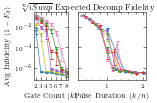

In [16]:
import itertools
marker = itertools.cycle(('o', '^', 's', 'd', 'v', '*')) 
color = itertools.cycle(("tab:blue", "tab:olive", "tab:purple", "tab:red", "tab:green", "tab:pink", "tab:orange", "tab:cyan"))
#color = itertools.cycle(("tab:green", "tab:pink", "tab:orange", "tab:cyan"))
base_fidelity_list = [.97, .98, 1-10e-3,1-5e-3, 1-10e-4, 1]
gate_error, decomp_error, fidelity_error = collect_random2q_data(1-10e-3, N=N, mode="random")
from scipy.stats import sem
def create_plot2(gate_error, decomp_error, fidelity_error, plot_bool):
    plt.style.use(['science'])#, 'ieee'])
    SMALL_SIZE = 4
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 12
    plt.rc("font", size=MEDIUM_SIZE+2)  # controls default text sizes
    plt.rc("axes", titlesize=MEDIUM_SIZE+2)  # fontsize of the axes title
    plt.rc("axes", labelsize=MEDIUM_SIZE + 1)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=SMALL_SIZE + 2)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=SMALL_SIZE + 2)  # fontsize of the tick labels
    plt.rc("legend", fontsize=MEDIUM_SIZE )  # legend fontsize
    plt.rc("figure", titlesize=MEDIUM_SIZE + 2)  # fontsize of the figure title
    plt.rc("lines", markersize=1.2, linewidth=.65)

    # fig = plt.figure()
    # gs = fig.add_gridspec(2,2)
    # ax1 = fig.add_subplot(gs[0, 0])
    # ax2 = fig.add_subplot(gs[0, 1])
    # ax3 = fig.add_subplot(gs[1, :])
    # axs = [ax1,ax2,ax3]

    if plot_bool:
        fig, axs = plt.subplots(1,2, figsize=(2,1.25), sharey=True,gridspec_kw={'width_ratios': [1,2]})
        for alpha_index in range(len(gate_error[0])):
                alpha = 1/alpha_range[alpha_index]
                set_color = next(color)
                set_marker = next(marker)
                #
                gate_unit_time = gate_range
                c = len([el for el in gate_unit_time if el <= 8])
                axs[0].errorbar(gate_unit_time[:c], [1-el for el in np.average(decomp_error, axis=0)[alpha_index][:c]], yerr=sem(decomp_error, axis=0)[alpha_index][:c], capsize=1.5, elinewidth=.5,  ecolor=set_color, label=r"$\sqrt[" + str(int(1/alpha))+ r"]{iSwap}$", marker=set_marker, color=set_color)
                #
                gate_unit_time = [el*alpha for el in gate_range]
                #gate_unit_time = gate_range
                #axs[1].plot(gate_unit_time, np.average(gate_error, axis=0)[alpha_index], label=f"Gate Error {alpha}", linestyle='--', marker='o')

                #cutting off values past 2 to make pulse duration plot look nicer
                c = len([el for el in gate_unit_time if el <= 2])
                c_bottom = len(gate_unit_time) - len([el for el in gate_unit_time if el >= 0])
                #c = len(gate_unit_time)
                axs[1].errorbar(gate_unit_time[c_bottom:c], [1-el for el in np.average(decomp_error, axis=0)[alpha_index][c_bottom:c]], yerr=sem(decomp_error, axis=0)[alpha_index][c_bottom:c], capsize=1.5, elinewidth=.5,  ecolor=set_color, label=r"$\sqrt[" + str(int(1/alpha))+ r"]{iSwap}$", marker=set_marker, color=set_color)
                #axs.errorbar(gate_unit_time, np.average(fidelity_error, axis=0)[alpha_index], yerr=sem(fidelity_error, axis=0)[alpha_index], label=f"Total Fidelity{alpha}", marker='^')
            #     axs[alpha_index].set_xlabel("Gate Unit Time")
                #axs[alpha_index].set_title(f"iSwap^(1/{1/alpha})")
        # for i, key in enumerate(np.max(np.average(fidelity_error, axis=0),axis=1)):
        #     axs[i].annotate(key, (i, frequency_list[key]))
        #     if i >= 3:
        #         break
        axs[0].set_yscale('log')
        #axs[1].set_xscale('log')
        axs[0].set_xlabel(r"Gate Count ($k$)")
        axs[1].set_xlabel(r"Pulse Duration ($k/n$)")
        fig.suptitle(r"$\sqrt[n]{iSwap}$ Expected Decomp Fidelity")
        #axs[0].legend(bbox_to_anchor=(2,-.2), ncol=2)
        handles, labels = axs[0].get_legend_handles_labels()
        #fig.legend(handles,labels,bbox_to_anchor=(.95,-.08),ncol=3)
        #axs[0].legend(bbox_to_anchor=(1.0,-.2), ncol=2)
        # axs[0].yaxis.set_major_locator(plt.LogitLocator(3))
        # axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
        # axs[-1].legend()
        axs[0].set_ylabel(r"Avg Infidelity ($1-F_d$)")
        axs[0].set_xticks(range(2,9))
        axs[0].minorticks_on()
        axs[0].xaxis.set_tick_params(which='minor', bottom=False, top=False)
    else: #if plot_bool:
        fig, axs = plt.subplots(1,1, figsize=(2,1.15), sharey=True)
        ydata = []
        ysem = []
        base_fidelity_list = np.arange(.9, 1, .01)
        for bf in base_fidelity_list:
            gate_error, decomp_error, fidelity_error = collect_random2q_data(bf, N=N, mode="random")
            ydata.append(get_max(fidelity_error)[0])
            ysem.append(get_max(fidelity_error)[1])
            #axs.errorbar([bf]*len(alpha_range), get_max(fidelity_error)[0], yerr=get_max(fidelity_error)[1], capsize=1.5, elinewidth=.5,  ecolor='black', linestyle="-", marker=next(marker), label=bf,color=next(color))
        for i, n in enumerate(range(len(gate_error[0]))):
            alpha = 1/alpha_range[i]
            set_color = next(color)
            axs.errorbar(base_fidelity_list, [el[i] for el in ydata], yerr=[el[i] for el in ysem], capsize=1, elinewidth=.5,  ecolor=set_color, linestyle="-", marker=next(marker), label=r"$\sqrt[" + str(int(1/alpha))+ r"]{iSwap}$",color=set_color)
        #axs.set_xlabel(r"$\sqrt[x]{iSwap}$")
        axs.set_xlabel(r"$F_b(\texttt{iSwap})$")
        axs.invert_xaxis()
        axs.set_yscale('linear')
        axs.minorticks_on()
        axs.xaxis.set_tick_params(which='minor', bottom=False, top=False)
    # # axs[1].set_ylabel("Avg fidelity")
    # # legend = axs[1].legend(title="iSwap Fidelity", bbox_to_anchor=(1.25,-.22), ncol=2)
        axs.legend(bbox_to_anchor=(1.0,-.22), ncol=3)
    # # legend._legend_box.align = "bottoms"
    # axs.yaxis.set_major_locator(plt.MaxNLocator(4))
        axs.set_xticks(np.linspace(.9, 1, 5))
    # #axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    #     # axs[1].set_title(f"Random 2Q Fidelity vs nth root iswap")
    #axs.set_yscale('log')
        axs.set_ylabel(r"Avg Total Fidelity $F_t$")
    #axs.set_ylabel("Average Fidelity")
        axs.set_title(r"$\sqrt[n]{iSwap}$ Expected Total Fidelity")
    #axs.minorticks_off()
    #axs.set_ylabel("Average Infidelity")
    #axs.set_xticks = [2,3,4,5,6,7,8]
    #axs.minorticks_off()
    #fig.suptitle(f"Random 2Q Fidelity (N={N})")
    #plt.axes().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    #fig.tight_layout()
    fig.show()
    filename = "nuop_experiment"
    fig.savefig('{}.svg'.format(filename), format="svg", facecolor=None)
create_plot2(gate_error, decomp_error, fidelity_error, plot_bool=False)

In [240]:
# base_fidelity_list = [1-10e-3,1-5e-3, 1-10e-4]
# fig, axs = plt.subplots(1, 1, sharey=True))
# for bf in base_fidelity_list:
#     gate_error, decomp_error, fidelity_error = collect_random2q_data(bf, N=25, mode="random")
#     axs.plot(alpha_range, np.max(np.average(fidelity_error, axis=0),axis=1), '-o', label=bf)
#     axs.set_xlabel("nth root iswap")
#     axs.set_ylabel("Avg fidelity")
#     axs.set_title(f"Random 2Q Fidelity vs nth root iswap")
#     axs.set_yscale('logit')

# fig.legend(loc='upper center', bbox_to_anchor=(0.5,0), ncol=3)
# fig.tight_layout()

In [241]:
# gate_error, decomp_error, fidelity_error = collect_random2q_data(1-5e-2, N=5, mode="swap")
# create_plot(gate_error, decomp_error, fidelity_error)

In [242]:
# base_fidelity_list = [1-10e-3,1-5e-3, 1-10e-4]
# fig, axs = plt.subplots(1, 1, sharey=True, figsize=(4, 4))
# for bf in base_fidelity_list:
#     gate_error, decomp_error, fidelity_error = collect_random2q_data(bf, N=5, mode="swap")
#     axs.plot(alpha_range, np.max(np.average(fidelity_error, axis=0),axis=1), '-o', label=bf)
#     axs.set_xlabel("nth root iswap")
#     axs.set_ylabel("max average fidelity")
#     axs.set_title(f"Max fidelity vs nth root iswap")
#     axs.set_yscale('logit')

# fig.legend()
# fig.tight_layout()

In [243]:
# #modify nuop so works with trotterization constraint - such that there is only U1 and U2 1Q gate solutions that are interleaved
# #eliminate gate_range parameter, beacuse now we must force the number of template reptetitions to be exactly n for nriswap
# #XXX
# from qiskit.converters import dag_to_circuit
# alpha_range = range(2,11)
# # alpha_range = [5]

# from qiskit.quantum_info import random_unitary

# def collect_trotterization_data(base_fidelity, N=15, mode="swap"):
#     base_fidelity = base_fidelity
#     empty_flag = 0
#     filename = f'data/trotter_{mode}.h5'
#     # filename = f'data/data5_{mode}.h5'
#     #load in previous data
#     try:
#         with h5py.File(filename, 'r') as h5f:
        
#             #gate_error = h5f['random2q_gate_error'][:]
#             decomp_error = h5f['decomp_error'][:]
#             #fidelity_error = h5f['random2q_fidelity_error'][:]

#             #backfill data
#             gate_error = np.zeros(shape=(len(decomp_error), len(alpha_range)))
#             fidelity_error = np.zeros(shape=(len(decomp_error), len(alpha_range)))
#             for i in range(len(decomp_error)):
#                 for alpha_index, alpha in enumerate(alpha_range):
#                     gate_count = alpha #constraint enforced by trotterization
#                     alpha = 1/alpha
#                     gate_error[i][alpha_index] = ((1-(alpha*(1-base_fidelity)))**gate_count)
#                     fidelity_error[i][alpha_index] = (decomp_error[i][alpha_index])*gate_error[i][alpha_index]

#     except Exception:
#         #case where data doesn't already exist
#         empty_flag = 1
#         decomp_error = []

#     for n in range(N-len(decomp_error)):

#         # if not empty_flag and len(gate_error) >= N:
#         #     break

#         qc = QuantumCircuit(2)
#         if mode == "random":
#             qc.append(random_unitary(dims=(2,2)),[0,1])
#         else:
#             qc.append(SwapGate(), [0,1])
#         dag = circuit_to_dag(qc)

#         #new data for this iteration
#         temp_gate_error = np.zeros(shape=(1, len(alpha_range)))
#         temp_decomp_error = np.zeros(shape=(1, len(alpha_range)))
#         temp_fidelity_error = np.zeros(shape=(1, len(alpha_range)))

#         for alpha_index, alpha in enumerate(alpha_range):
#             gate_count = alpha #constraint enforced by trotterization
#             alpha = 1/alpha
#             params = [[alpha]]
#             gate_labels = [f'$iSwap^{alpha}$']
#             gate_defs = [RiSwapGate]

#             temp_gate_error[0][alpha_index] = ((1-(alpha*(1-base_fidelity)))**gate_count)
        
#             #run perfect if it doesn't already exist
#             fid_2q = {(0,1):[1]}
#             pgrp = ParallelGateReplacementPass(gate_defs, params ,fid_2q, fidelity_list_1q_gate=[1 for _ in range(54)], tol=1e-10, force_gate_count=gate_count,trotterization=True)
#             approx = pgrp.run(dag)
#             #print(dag_to_circuit(approx).draw(fold=-1))
#             print(f"Completed iter{n}, gate {alpha}...")
#             temp_decomp_error[0][alpha_index] = (pgrp.property_set["best_fid"])
#             temp_fidelity_error[0][alpha_index] = (temp_gate_error[0][alpha_index])*temp_decomp_error[0][alpha_index]

#                 #run noisy
#                 # fid_2q = {(0,1):[1-alpha*(1-base_fidelity)]}
#                 # pgrp = ParallelGateReplacementPass(gate_defs, params ,fid_2q, fidelity_list_1q_gate=[1 for _ in range(54)], tol=1e-10, force_gate_count=gate_count)
#                 # approx = pgrp.run(dag)
#                 # temp_fidelity_error[0][alpha_index][gate_index] = (pgrp.property_set["best_fid"])

#                 #these are equivalent - save some time and just calculate it using the previous values
                
#                 # print(f"{gate_error[-1]}, {decomp_error[-1]}, {fidelity_error[-1]}")

#             #update data

#         if empty_flag:
#             gate_error = temp_gate_error
#             decomp_error = temp_decomp_error
#             fidelity_error = temp_fidelity_error
#             empty_flag = 0
#         else:
#             gate_error = np.append(gate_error, temp_gate_error, axis=0)
#             decomp_error = np.append(decomp_error, temp_decomp_error, axis=0)
#             fidelity_error = np.append(fidelity_error, temp_fidelity_error, axis=0)

#         #write back data after each iteration in case we end early
#         with h5py.File(filename, 'a') as h5f:
#             print(f"saving iter {n}")
#             # delete old, differently sized dataset
#             try:
#                 del h5f['gate_error'] 
#                 del h5f['decomp_error']
#                 del h5f['fidelity_error']
#             except Exception:
#                 #don't need to delete if they don't exist
#                 pass
#             h5f.create_dataset('gate_error', data=gate_error)
#             h5f.create_dataset('decomp_error', data=decomp_error)
#             h5f.create_dataset('fidelity_error', data=fidelity_error)
        
#     return gate_error, decomp_error, fidelity_error

In [244]:
# gate_error, decomp_error, fidelity_error = collect_trotterization_data(base_fidelity, N=1, mode="swap")

In [245]:
# gate_error.shape

In [246]:
# decomp_error

In [247]:
# gate_count = 3 #constraint enforced by trotterization
# alpha = 1/gate_count

# from qiskit.circuit.library.standard_gates import *
# qc = QuantumCircuit(2)
# mode = "swap"
# if mode == "random":
#     qc.append(random_unitary(dims=(2,2)),[0,1])
# else:
#     #qc.append(SwapGate(), [0,1])
#     qc.append(CXGate(), [0,1])
# dag = circuit_to_dag(qc)
# params = [[alpha]]
# gate_labels = [r"$\sqrt[" + str(int(1/alpha))+ r"]{iSwap}$"]
# gate_defs = [RiSwapGate]
# fid_2q = {(0,1):[1]}
# pgrp = ParallelGateReplacementPass(gate_defs, params ,fid_2q, fidelity_list_1q_gate=[1 for _ in range(54)], tol=1e-10, force_gate_count=gate_count)
# approx = pgrp.run(dag)
# print(f"Completed iter, gate {alpha}...")
# t = (pgrp.property_set["best_fid"])
# print(t)
# print(dag_to_circuit(approx).draw(output='mpl'))

In [248]:
# gate = Operator(dag_to_circuit(approx)).data
# gate = Operator(CXGate()).data
# import weylchamber
# c1, c2, c3 = weylchamber.c1c2c3(gate)
# print(c1,c2,c3)

In [249]:
# import itertools
# marker = itertools.cycle(('o', '^', 's', 'd')) 
# color = itertools.cycle(("tab:blue", "tab:olive", "tab:purple", "tab:red", "tab:green", "tab:pink", "tab:orange", "tab:cyan"))
# #color = itertools.cycle(("tab:green", "tab:pink", "tab:orange", "tab:cyan"))
# base_fidelity_list = [1-10e-3,1-5e-3, 1-10e-4, 1]
# gate_error, decomp_error, fidelity_error = collect_trotterization_data(base_fidelity, N=1, mode="swap")
# from scipy.stats import sem
# def create_plot3(gate_error, decomp_error, fidelity_error):
#     plt.style.use(['science', 'ieee'])
#     SMALL_SIZE = 4
#     MEDIUM_SIZE = 6
#     BIGGER_SIZE = 12
#     plt.rc("font", size=MEDIUM_SIZE+2)  # controls default text sizes
#     plt.rc("axes", titlesize=MEDIUM_SIZE+2)  # fontsize of the axes title
#     plt.rc("axes", labelsize=MEDIUM_SIZE + 1)  # fontsize of the x and y labels
#     plt.rc("xtick", labelsize=SMALL_SIZE + 2)  # fontsize of the tick labels
#     plt.rc("ytick", labelsize=SMALL_SIZE + 2)  # fontsize of the tick labels
#     plt.rc("legend", fontsize=MEDIUM_SIZE + 2)  # legend fontsize
#     plt.rc("figure", titlesize=MEDIUM_SIZE + 4)  # fontsize of the figure title
#     plt.rc("lines", markersize=2, linewidth=.75)
#     fig, axs = plt.subplots(1,1, figsize=(2,1.75))
#     if True:
#         for alpha_index in range(len(gate_error[0])):
#                 alpha = 1/alpha_range[alpha_index]
#                 gate_unit_time = [el*alpha for el in gate_range]
#                 gate_unit_time = gate_range
#                 #axs[1].plot(gate_unit_time, np.average(gate_error, axis=0)[alpha_index], label=f"Gate Error {alpha}", linestyle='--', marker='o')
#                 axs.errorbar(gate_unit_time, [1-el for el in np.average(decomp_error, axis=0)[alpha_index]], yerr=sem(decomp_error, axis=0)[alpha_index], capsize=1.5, elinewidth=.5,  ecolor='black', label=r"$\sqrt[" + str(int(1/alpha))+ r"]{iSwap}$", marker=next(marker), color=next(color))
#                 #axs.errorbar(gate_unit_time, np.average(fidelity_error, axis=0)[alpha_index], yerr=sem(fidelity_error, axis=0)[alpha_index], label=f"Total Fidelity{alpha}", marker='^')
#             #     axs[alpha_index].set_xlabel("Gate Unit Time")
#                 #axs[alpha_index].set_title(f"iSwap^(1/{1/alpha})")
#         # for i, key in enumerate(np.max(np.average(fidelity_error, axis=0),axis=1)):
#         #     axs[i].annotate(key, (i, frequency_list[key]))
#         #     if i >= 3:
#         #         break
#         axs.set_yscale('log')
#         axs.set_xlabel("2Q Gate Count")
#         axs.set_title("Decomp Infidelity")
#         axs.legend(bbox_to_anchor=(1.2,-.2), ncol=2)
#         axs.legend(bbox_to_anchor=(1.0,-.2), ncol=2)
#         # axs[0].yaxis.set_major_locator(plt.LogitLocator(3))
#         # axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
#         # axs[-1].legend()
#         axs.set_ylabel("Avg Fidelity")
#     else:
#         for bf in base_fidelity_list:
#             gate_error, decomp_error, fidelity_error = collect_random2q_data(bf, N=N, mode="random")
#             x_axis = alpha_range
#             axs.errorbar(x_axis, get_max(fidelity_error)[0], yerr=get_max(fidelity_error)[1], capsize=1.5, elinewidth=.5,  ecolor='black', linestyle="-", marker=next(marker), label=bf,color=next(color))

#         axs.set_xlabel(r"$\sqrt[x]{iSwap}$")
#     # # axs[1].set_ylabel("Avg fidelity")
#     # # legend = axs[1].legend(title="iSwap Fidelity", bbox_to_anchor=(1.25,-.22), ncol=2)
#         axs.legend(bbox_to_anchor=(1.25,-.22), ncol=2)
#     # # legend._legend_box.align = "bottoms"
#     # axs.yaxis.set_major_locator(plt.MaxNLocator(4))
#         axs.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
#     # #axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

#     # axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
#     #     # axs[1].set_title(f"Random 2Q Fidelity vs nth root iswap")
#     #axs.set_yscale('log')
#         axs.set_ylabel("Avg Infidelity")
#     #axs.set_ylabel("Average Fidelity")
#         axs.set_title("Best Total Fidelity")
#     #axs.minorticks_off()
#     #axs.set_ylabel("Average Infidelity")
#     #axs.set_xticks = [2,3,4,5,6,7,8]
#     #axs.minorticks_off()
#     #fig.suptitle(f"Random 2Q Fidelity (N={N})")
#     #plt.axes().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
#     #fig.tight_layout()
#     fig.show()
#     filename = "nuop_experiment"
#     fig.savefig('{}.pdf'.format(filename), format="pdf", facecolor='white')
# create_plot2(gate_error, decomp_error, fidelity_error)